In [1]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
fake_news_df = pd.read_csv("/content/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [4]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna('missing', inplace=True)
fake_news_df['text'].fillna('missing', inplace=True)

# replace NaN values in 'author' with 'unknown'
fake_news_df['author'].fillna('unknown', inplace=True)

1    10413
0    10387
Name: label, dtype: int64


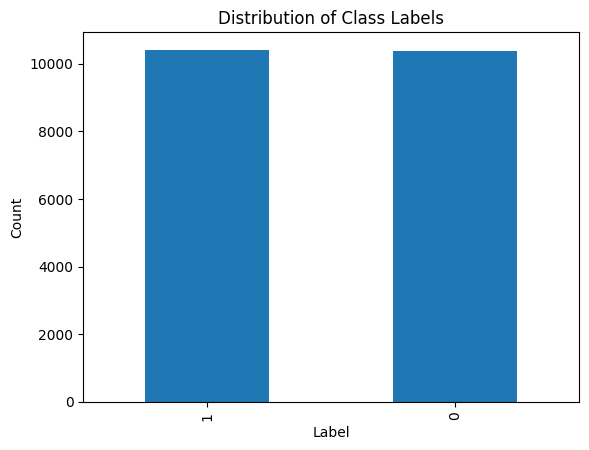

In [6]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()


To make any models we have to use either text column or combination of author and title columns. Due to large paragraphs in text columns we would try this option as well.

**Merging author and title columns**

In [7]:
fake_news_df['content'] = fake_news_df['author']+' '+fake_news_df['title']

In [8]:
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [9]:
#Seperate data and target (label)

X = fake_news_df.drop('label', axis=1)
y = fake_news_df['label']


In [10]:
print(X)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [11]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64


**Stemming: reduce words to their root**

In [12]:
#insignificant words
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
port_stem = PorterStemmer()

In [15]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]+',' ', content) #include only alphabets (all numbers and punctuations will be removed)
  stemmed_content = stemmed_content.lower() #convert all alphabets into lower case
  stemmed_content = stemmed_content.split() #split and convert to list
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  #stem all the words that are not in stopwords
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [16]:
#apply stemming function to content column
fake_news_df['content'] = fake_news_df['content'].apply(stemming)

In [17]:
print(fake_news_df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


There is only lower case words in content column now

In [18]:
#apply stemming function to text column
fake_news_df['text'] = fake_news_df['text'].apply(stemming)

In [19]:
print(fake_news_df['text'])

0        hous dem aid even see comey letter jason chaff...
1        ever get feel life circl roundabout rather hea...
2        truth might get fire octob tension intellig an...
3        video civilian kill singl us airstrik identifi...
4        print iranian woman sentenc six year prison ir...
                               ...                        
20795    rapper unload black celebr met donald trump el...
20796    green bay packer lost washington redskin week ...
20797    maci today grew union sever great name america...
20798    nato russia hold parallel exercis balkan press...
20799    david swanson author activist journalist radio...
Name: text, Length: 20800, dtype: object


In [20]:
fake_news_df

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,hous dem aid even see comey letter jason chaff...,1,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feel life circl roundabout rather hea...,0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fire octob tension intellig an...,1,consortiumnew com truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,video civilian kill singl us airstrik identifi...,1,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print iranian woman sentenc six year prison ir...,1,howard portnoy iranian woman jail fiction unpu...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,rapper unload black celebr met donald trump el...,0,jerom hudson rapper trump poster child white s...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,green bay packer lost washington redskin week ...,0,benjamin hoffman n f l playoff schedul matchup...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,maci today grew union sever great name america...,0,michael j de la merc rachel abram maci said re...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,nato russia hold parallel exercis balkan press...,1,alex ansari nato russia hold parallel exercis ...


In [21]:
#seperate x and y
X1 = fake_news_df['content'].values
y1 = fake_news_df['label'].values

In [63]:

X1.shape

(20800, 17128)

In [64]:
print(y1)
y1.shape

[1 0 1 ... 0 1 1]


(20800,)

convert all the texts into numbers using TfidfVectorizer package

In [30]:
vectorizer=TfidfVectorizer()
vectorizer.fit(X1)

TfidfVectorizer()

In [31]:
X1=vectorizer.transform(X1)

In [32]:
print(X1)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

Split data into train and test 80/20

In [33]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2, random_state=42)

**1) Create model using content column as indicator**

**Logistic Regression**

In [93]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X1_train, y1_train)


LogisticRegression()

In [94]:
#accuracy score on train data
X1_train_pred = LR.predict(X1_train)
LR_train_accuracy = accuracy_score(X1_train_pred, y1_train)

In [95]:
print("Accuracy score of train data : ", LR_train_accuracy )

Accuracy score of train data :  0.9907451923076923


In [96]:
#prediction
pred_LR = LR.predict(X1_test)

In [97]:
#accuracy score on test data
LR_test_accuracy = accuracy_score(pred_LR, y1_test)
print("Accuracy score of test data : ", LR_test_accuracy )

Accuracy score of test data :  0.9788461538461538


In [98]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y1_test, pred_LR))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2132
           1       0.97      0.99      0.98      2028

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



**Decision Tree**

In [99]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X1_train, y1_train)


DecisionTreeClassifier()

In [100]:
#accuracy score on train data
X1_train_pred_DT = DT.predict(X1_train)
DT_train_accuracy = accuracy_score(X1_train_pred_DT, y1_train)

In [101]:
print("Accuracy score of train data : ", DT_train_accuracy )

Accuracy score of train data :  1.0


In [102]:
#prediction
pred_DT = DT.predict(X1_test)

In [103]:
#accuracy score on test data
DT_test_accuracy = accuracy_score(pred_DT, y1_test)
print("Accuracy score of test data : ", DT_test_accuracy )

Accuracy score of test data :  0.9920673076923077


In [104]:
#classification report
print(classification_report(y1_test, pred_DT))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2132
           1       0.99      0.99      0.99      2028

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



**Gradient Boosting Classifier**

In [105]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=1)
GB.fit(X1_train, y1_train)


GradientBoostingClassifier(random_state=1)

In [106]:
#accuracy score on train data
X1_train_pred_GB = GB.predict(X1_train)
GB_train_accuracy = accuracy_score(X1_train_pred_GB, y1_train)

In [107]:
print("Accuracy score of train data : ", GB_train_accuracy )

Accuracy score of train data :  0.9680288461538461


In [108]:
#prediction
pred_GB = GB.predict(X1_test)

In [109]:
#accuracy score on test data
GB_test_accuracy = accuracy_score(pred_GB, y1_test)
print("Accuracy score of test data : ", GB_test_accuracy )

Accuracy score of test data :  0.9584134615384615


In [110]:
#classification report
print(classification_report(y1_test, pred_GB))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2132
           1       0.93      0.99      0.96      2028

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



**Random Forest**

In [111]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=1)
RF.fit(X1_train, y1_train)

RandomForestClassifier(random_state=1)

In [112]:
#accuracy score on train data
X1_train_pred_RF = RF.predict(X1_train)
RF_train_accuracy = accuracy_score(X1_train_pred_RF, y1_train)

In [113]:
print("Accuracy score of train data : ", RF_train_accuracy )

Accuracy score of train data :  1.0


In [114]:
#prediction
pred_RF = RF.predict(X1_test)

In [115]:
#accuracy score on test data
RF_test_accuracy = accuracy_score(pred_RF, y1_test)
print("Accuracy score of test data : ", RF_test_accuracy )

Accuracy score of test data :  0.9920673076923077


In [116]:
#classification report
print(classification_report(y1_test, pred_RF))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2132
           1       0.99      0.99      0.99      2028

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



**2) Create model using text column as indicator**

In [117]:
#seperate x and y
X2 = fake_news_df['text'].values
y2 = fake_news_df['label'].values

In [118]:
X2.shape


(20800,)

In [119]:
y2.shape

(20800,)

**convert all the texts into numbers using TfidfVectorizer package**

In [120]:
vectorizer=TfidfVectorizer()
vectorizer.fit(X2)

TfidfVectorizer()

In [121]:
X2 = vectorizer.transform(X2)

In [122]:
print (X2)

  (0, 108701)	0.05247338102196001
  (0, 108648)	0.02039426321726478
  (0, 107704)	0.047239651687820045
  (0, 107700)	0.10136808063785403
  (0, 107657)	0.040374166404919226
  (0, 107620)	0.012086117790734634
  (0, 106976)	0.018383370414756055
  (0, 106176)	0.018269731853209667
  (0, 106088)	0.013396626135405348
  (0, 106003)	0.03120259501981026
  (0, 105927)	0.01374766445058099
  (0, 105727)	0.012597763189386674
  (0, 104888)	0.027660719789118264
  (0, 104853)	0.03349685835652778
  (0, 103857)	0.02301499513681735
  (0, 102455)	0.06985897849015364
  (0, 101772)	0.03541621007204582
  (0, 101522)	0.01750907631568824
  (0, 100755)	0.040639365493345306
  (0, 100117)	0.011840757024912692
  (0, 100107)	0.04614899718186797
  (0, 100055)	0.12133995257889348
  (0, 99907)	0.07641534922876257
  (0, 98625)	0.04211025487587547
  (0, 98062)	0.0289605384680031
  :	:
  (20799, 7405)	0.01072938433020128
  (20799, 7081)	0.028352482045912016
  (20799, 6788)	0.04019926502055583
  (20799, 6750)	0.02549682701

In [123]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.2, random_state=42)

**Logistic Regression**

In [124]:
LR2 = LogisticRegression()
LR2.fit(X2_train, y2_train)

LogisticRegression()

In [126]:
#accuracy score on train data
X2_train_pred = LR2.predict(X2_train)
LR2_train_accuracy = accuracy_score(X2_train_pred, y2_train)

In [127]:
print("Accuracy score of train data : ", LR2_train_accuracy )

Accuracy score of train data :  0.9712740384615385


In [128]:
#prediction
pred_LR2 = LR2.predict(X2_test)

In [129]:
#accuracy score on test data
LR2_test_accuracy = accuracy_score(pred_LR2, y2_test)
print("Accuracy score of test data : ", LR2_test_accuracy )

Accuracy score of test data :  0.94375


In [130]:
#classification report
print(classification_report(y2_test, pred_LR2))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2132
           1       0.94      0.95      0.94      2028

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



**Decision Tree**

In [131]:
DT2 = DecisionTreeClassifier()
DT2.fit(X2_train, y2_train)


DecisionTreeClassifier()

In [132]:
#accuracy score on train data
X2_train_pred_DT2 = DT2.predict(X2_train)
DT2_train_accuracy = accuracy_score(X2_train_pred_DT2, y2_train)
print("Accuracy score of train data : ", DT2_train_accuracy )

Accuracy score of train data :  0.9999399038461538


In [133]:
#prediction
pred_DT2 = DT2.predict(X2_test)

#accuracy score on test data
DT2_test_accuracy = accuracy_score(pred_DT2, y2_test)
print("Accuracy score of test data : ", DT2_test_accuracy )

Accuracy score of test data :  0.8814903846153846


In [134]:
#classification report
print(classification_report(y2_test, pred_DT2))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2132
           1       0.87      0.88      0.88      2028

    accuracy                           0.88      4160
   macro avg       0.88      0.88      0.88      4160
weighted avg       0.88      0.88      0.88      4160



**Gradient Boosting Classifier**

In [135]:
GB2 = GradientBoostingClassifier(random_state=1)
GB2.fit(X2_train, y2_train)

GradientBoostingClassifier(random_state=1)

In [136]:
#accuracy score on train data
X2_train_pred_GB2 = GB2.predict(X2_train)
GB2_train_accuracy = accuracy_score(X2_train_pred_GB2, y2_train)
print("Accuracy score of train data : ", GB2_train_accuracy )

Accuracy score of train data :  0.9364182692307692


In [137]:
#prediction
pred_GB2 = GB2.predict(X2_test)

#accuracy score on test data
GB2_test_accuracy = accuracy_score(pred_GB2, y2_test)
print("Accuracy score of test data : ", GB2_test_accuracy )

Accuracy score of test data :  0.9276442307692307


In [138]:
#classification report
print(classification_report(y2_test, pred_GB2))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2132
           1       0.92      0.94      0.93      2028

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



**Random Forest**

In [139]:
RF2 = RandomForestClassifier(random_state=1)
RF2.fit(X2_train, y2_train)

RandomForestClassifier(random_state=1)

In [140]:
#accuracy score on train data
X2_train_pred_RF2 = RF2.predict(X2_train)
RF2_train_accuracy = accuracy_score(X2_train_pred_RF2, y2_train)
print("Accuracy score of train data : ", RF2_train_accuracy )

Accuracy score of train data :  0.9999399038461538


In [141]:
#prediction
pred_RF2 = RF2.predict(X2_test)

#accuracy score on test data
RF2_test_accuracy = accuracy_score(pred_RF2, y2_test)
print("Accuracy score of test data : ", RF2_test_accuracy )

Accuracy score of test data :  0.9091346153846154


In [142]:
#classification report
print(classification_report(y2_test, pred_RF2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2132
           1       0.93      0.88      0.90      2028

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160

